In [ ]:
!pip install transformers datasets accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.5 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json
from datasets import load_dataset
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML
from transformers import get_scheduler, SchedulerType
from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from tqdm.auto import tqdm
import torch
import pandas as pd
import math

In [ ]:
# define predefined set of aspect categories and polarities
aspectCategories=["food", "service", "price", "ambience", "anecdotes/miscellaneous"]
polarities=["positive", "neutral","negative", "conflict", "none"]
polarity2id={polarity: id for id, polarity in enumerate(polarities)}
id2polarity={id: polarity for id, polarity in enumerate(polarities)}

# define constants
aspects=["food", "service", "price", "ambience", "anecdotes/miscellaneous"]
# polarities=["positive", "neutral", "negative", "conflict", "none"]
aspects2Ind={v: k for k, v in enumerate(aspects)}
ind2Aspects={k: v for k, v in enumerate(aspects)}
polarities2Ind={v: k for k, v in enumerate(polarities)}
ind2Polarities={k: v for k, v in enumerate(polarities)}

In [ ]:
def find_new_i(data, i):
    i+=1
    while data[i]==' ':
        i+=1
    return i

def modify_array_representation(data):
    res=""
    number_of_open_bracket=0
    i=0
    while i < len(data):
        if data[i]=='[':
            number_of_open_bracket+=1
            res=res+"["
            i+=1
        elif data[i]==']':
            number_of_open_bracket-=1
            res=res+"]"
            i+=1
        elif data[i]=='\n':
            if number_of_open_bracket > 1:
                res=res+" "
                i=find_new_i(data, i)
            else:
                res=res+"\n"
                i+=1
        else:
            res=res+data[i]
            i+=1
    return res

def write_file(data, file_name):
    json_data=json.dumps(data, indent=4)
    json_data=modify_array_representation(json_data)
    file = open(file_name, "w")
    file.write(json_data)
    file.close()

# Helper function: convert XML data to JSON
# fileDir: directory of XML file
# resDir: directory of returned Json file
def convertXMLToJson(fileDir, resDir):
  # XML format:
  # <sentence>
  # <text>User's review</text>
  # <aspectCategories>
  # <aspectCategory category=category polarity=polarity/>
  # </aspectCategories>
  # <sentences>
  #
  # Json format
  # [
  # {
  # text: User's review,
  # polarity: [food's polarity, service's polarity, price's polarity, ambience's polarity, a/m's polarity]
  # },
  # ]
  f = open(fileDir, "r")
  xmlContent=f.read() # load whole file to RAM
  # for each <sentence></sentence>
  curInd=0
  list_json=[]
  while curInd>=0:
    start=xmlContent.find("<sentence", curInd)
    end=xmlContent.find("</sentence>", curInd)
    if start<0 or end<0:
      break
    # read <text></text>
    startText=xmlContent.find("<text>", start, end)
    endText=xmlContent.find("</text>", start, end)
    text=xmlContent[startText+len("<text>"): endText]
    polarity=[]
    for aspect in aspects:
      polarity.append(polarities2Ind["none"])
    # real all <aspectCategory/> within [start, end]
    curStart=start
    while True:
      startAP=xmlContent.find("<aspectCategory", curStart, end)
      if startAP<0:
        break
      startCate=xmlContent.find("category=\"", startAP)
      endCate=xmlContent.find("\" ", startCate+len("category=\""))
      cate=xmlContent[startCate+len("category=\""): endCate]
      startPolarity=xmlContent.find("polarity=\"", startAP)
      endPolarity=xmlContent.find("\"", startPolarity+len("polarity=\""))
      pol=xmlContent[startPolarity+len("polarity=\""): endPolarity]
      # print("cate=", cate, "pol=", pol)
      polarity[aspects2Ind[cate]]=polarities2Ind[pol]
      curStart=endPolarity+len("\"")+1
    item={}
    item["text"]=text
    item["polarity"]=polarity
    list_json.append(item)
    curInd=end+len("</sentence>")
  write_file(list_json, resDir)

convertXMLToJson("Restaurants_Test_Gold.xml", "Restaurants_Test_Gold.json")
convertXMLToJson("Restaurants_Train.xml", "Restaurants_Train.json")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

pretrained_model="microsoft/deberta-large"
tokenizer=AutoTokenizer.from_pretrained(pretrained_model)
model=AutoModelForSequenceClassification.from_pretrained(pretrained_model, label2id=polarity2id, id2label=id2polarity)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import load_dataset

def reformat_sentence_batch(batch):
  new_batch={"text": [], "labels": []}
  new_format="{aspect}... {sentence}"
  for sentence, sentiment_item in zip(batch["text"], batch["polarity"]):
    for aspect, polarity in zip(aspectCategories, sentiment_item):
      new_sentence=new_format.format(aspect=aspect, sentence=sentence)
      new_batch["text"].append(new_sentence)
      new_batch["labels"].append(polarity)
  return new_batch

def tokenize_batch(batch):
  result=tokenizer(batch["text"], return_tensors="pt", padding="longest")
  return result

def preprocess_train_dataset(train_dataset):
  # reformat sentence
  train_dataset=train_dataset.map(
      reformat_sentence_batch,
      batched=True,
      remove_columns=["polarity"]
  )
  # train_dataset=train_dataset["train"].train_test_split(test_size=0.2)
  # tokenize sentences
  train_dataset=train_dataset.map(
      tokenize_batch,
      batched=True,
      batch_size=None,
      remove_columns=["text"],
  )
  return train_dataset

train_dataset=load_dataset("json", data_files="Restaurants_Train.json")
test_dataset=load_dataset("json", data_files="Restaurants_Test_Gold.json")

train_dataset=preprocess_train_dataset(train_dataset)
print("train_dataset:", train_dataset)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/3044 [00:00<?, ? examples/s]

Map:   0%|          | 0/15220 [00:00<?, ? examples/s]

train_dataset: DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15220
    })
})


In [ ]:
import math

def compute_aspect_category_polarity(new_sentence):
  # return list of probabilities for each polarity
  # sentence must be reformatted to new format before send to this function
  inputs=tokenizer(new_sentence, return_tensors="pt")
  inputs.to("cuda") # if model haven't be .to("cuda") yet, comment this line
  outputs=model(**inputs)
  logits=outputs.logits # logits shape: n sentence = 1, n polarity=len(polarities)
  return compute_probabilities(logits[0])

def compute_polarity(sentence):
  # return list<list<float>> a
  # a[i][j] = probability that the polarity of aspect category i is j
  new_format="{aspect}... {sentence}"
  a=[]
  for aspect in aspectCategories:
    new_sentence=new_format.format(aspect=aspect, sentence=sentence)
    a.append(compute_aspect_category_polarity(new_sentence))
  return a

def compute_probabilities(logits):
  # normalize logits to probabilities
  list_probabilities=[]
  sum_item=0
  for logit in logits:
    list_item=math.pow(math.e, logit.item())
    list_probabilities.append(list_item)
    sum_item+=list_item
  for i in range(len(list_probabilities)):
    list_probabilities[i]=list_probabilities[i]/sum_item
  return list_probabilities

def evaluate_model():
  # evaluate model for 2 subtask 3 and 4
  total_3=0
  predict_3=0
  predict_correct_3=0
  total_4=0
  correct_4=0
  for record in test_dataset["train"]:
    list_probabilities=compute_polarity(record["text"])
    # compute subtask 3
    subtask3_predict_set=set()
    for i, aspect_probabilities in enumerate(list_probabilities):
      max_polarity=0
      for j, prob in enumerate(aspect_probabilities):
        if prob > aspect_probabilities[max_polarity]:
          max_polarity=j
      if max_polarity != 4:
        # polarity of this aspect is not none
        subtask3_predict_set.add(i)
    subtask3_total_set=set()
    for i, s in enumerate(record["polarity"]):
      if s!=4:
        subtask3_total_set.add(i)
    subtask3_correct_set=subtask3_predict_set.intersection(subtask3_total_set)
    total_3+=len(subtask3_total_set)
    predict_3+=len(subtask3_predict_set)
    predict_correct_3+=len(subtask3_correct_set)
    # compute subtask 4
    for aspect_label, aspect_probability in zip(record["polarity"], list_probabilities):
      if aspect_label==4:
        # aspect_label is none
        continue
      total_4+=1
      max_polarity=0
      for i in range(len(aspect_probability)-1):
        if aspect_probability[i] > aspect_probability[max_polarity]:
          max_polarity=i
      if aspect_label==max_polarity:
        correct_4+=1
  precision_3=predict_correct_3/predict_3
  recall_3=predict_correct_3/total_3
  f1_3=2*(precision_3 * recall_3)/(precision_3+recall_3)
  acc_4=correct_4/total_4
  return {
      "f1_3": f1_3,
      "acc_4": acc_4,
      "precision_3": precision_3,
      "recall_3": recall_3,
      "total_3": total_3,
      "predict_3": predict_3,
      "correct_3": predict_correct_3,
      "total_4": total_4,
      "correct_4": correct_4
  }

# evaluate_model()

In [ ]:
from transformers import get_scheduler, SchedulerType
from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from tqdm.auto import tqdm
import torch
import pandas as pd
from IPython.display import HTML

train_dataset.set_format("torch")

batch_size=16
train_dataloader=DataLoader(train_dataset["train"], batch_size=batch_size, shuffle=True)
# test_dataloader=DataLoader(train_dataset["test"], batch_size=None)

weight_decay=0
lr=2e-5
optimizer=AdamW(
    model.parameters(),
    weight_decay=weight_decay,
    lr=lr
)

name=SchedulerType.LINEAR
num_warmup_steps=40
num_epochs=5
num_train_steps=len(train_dataloader)*num_epochs
lr_scheduler=get_scheduler(
  name,
  optimizer=optimizer,
  num_warmup_steps=num_warmup_steps,
  num_training_steps=num_train_steps
)

accelerator=Accelerator()
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

report={
    "epoch": [],
    "train_loss": [],
    "subtask3.f1": [],
    "subtask4.acc": [],
    "subtask3.precision": [],
    "subtask3.recall": [],
    "subtask3.predict_and_correct": [],
    "subtask3.predict": [],
    "subtask3.total": [],
    "subtask4.correct": [],
    "subtask4.total": []
}

progress_bar=tqdm(range(num_train_steps))

model.train()
for epoch in range(num_epochs):
  print("===== EPOCH {i} ====".format(i=epoch))

  train_loss=0
  for batch in train_dataloader:
    outputs=model(**batch)
    loss=outputs.loss
    train_loss+=loss.item()
    accelerator.backward(loss)

    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)

  evaluate_result=evaluate_model()

  report["epoch"].append(epoch+1)
  report["train_loss"].append(train_loss)
  report["subtask3.f1"].append(evaluate_result["f1_3"])
  report["subtask3.precision"].append(evaluate_result["precision_3"])
  report["subtask3.recall"].append(evaluate_result["recall_3"])
  report["subtask3.predict_and_correct"].append(evaluate_result["correct_3"])
  report["subtask3.predict"].append(evaluate_result["predict_3"])
  report["subtask3.total"].append(evaluate_result["total_3"])
  report["subtask4.acc"].append(evaluate_result["acc_4"])
  report["subtask4.correct"].append(evaluate_result["correct_4"])
  report["subtask4.total"].append(evaluate_result["total_4"])

  df=pd.DataFrame(report)
  display(df)

  print()
  print()

  0%|          | 0/4760 [00:00<?, ?it/s]

===== EPOCH 0 ====


,epoch,train_loss,subtask3.f1,subtask4.acc,subtask3.precision,subtask3.recall,subtask3.predict_and_correct,subtask3.predict,subtask3.total,subtask4.correct,subtask4.total
0,1,446.947771,0.907622,0.837073,0.940377,0.877073,899,956,1025,858,1025




===== EPOCH 1 ====


,epoch,train_loss,subtask3.f1,subtask4.acc,subtask3.precision,subtask3.recall,subtask3.predict_and_correct,subtask3.predict,subtask3.total,subtask4.correct,subtask4.total
0,1,446.947771,0.907622,0.837073,0.940377,0.877073,899,956,1025,858,1025
1,2,214.244311,0.891975,0.879024,0.943417,0.845854,867,919,1025,901,1025




===== EPOCH 2 ====


,epoch,train_loss,subtask3.f1,subtask4.acc,subtask3.precision,subtask3.recall,subtask3.predict_and_correct,subtask3.predict,subtask3.total,subtask4.correct,subtask4.total
0,1,446.947771,0.907622,0.837073,0.940377,0.877073,899,956,1025,858,1025
1,2,214.244311,0.891975,0.879024,0.943417,0.845854,867,919,1025,901,1025
2,3,125.944565,0.923758,0.873171,0.931548,0.916098,939,1008,1025,895,1025




===== EPOCH 3 ====


,epoch,train_loss,subtask3.f1,subtask4.acc,subtask3.precision,subtask3.recall,subtask3.predict_and_correct,subtask3.predict,subtask3.total,subtask4.correct,subtask4.total
0,1,446.947771,0.907622,0.837073,0.940377,0.877073,899,956,1025,858,1025
1,2,214.244311,0.891975,0.879024,0.943417,0.845854,867,919,1025,901,1025
2,3,125.944565,0.923758,0.873171,0.931548,0.916098,939,1008,1025,895,1025
3,4,63.784876,0.924963,0.895610,0.929980,0.920000,943,1014,1025,918,1025




===== EPOCH 4 ====


,epoch,train_loss,subtask3.f1,subtask4.acc,subtask3.precision,subtask3.recall,subtask3.predict_and_correct,subtask3.predict,subtask3.total,subtask4.correct,subtask4.total
0,1,446.947771,0.907622,0.837073,0.940377,0.877073,899,956,1025,858,1025
1,2,214.244311,0.891975,0.879024,0.943417,0.845854,867,919,1025,901,1025
2,3,125.944565,0.923758,0.873171,0.931548,0.916098,939,1008,1025,895,1025
3,4,63.784876,0.924963,0.895610,0.929980,0.920000,943,1014,1025,918,1025
4,5,25.269637,0.928111,0.894634,0.943548,0.913171,936,992,1025,917,1025


In [ ]:
from huggingface_hub import HfApi, create_repo, notebook_login

notebook_login()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from huggingface_hub import HfApi, create_repo, notebook_login

api = HfApi()

repo_name="Thesis-SentimentAnalysis-3"
repo_dir="/{repo_name}".format(repo_name=repo_name)
repo_id="{user}/{repo}".format(user="UchihaMadara", repo=repo_name)

create_repo(repo_id)
tokenizer.save_pretrained(repo_dir)
model.save_pretrained(repo_dir)

# create README.md file

train_result=""
for i in range(len(report["epoch"])):
  temp_result="|{epoch}|{train_loss}|{subtask3_f1}|{subtask3_precision}|{subtask3_recall}|{subtask4_accuracy}|\n"
  temp_result=temp_result.format(epoch=report["epoch"][i], train_loss=report["train_loss"][i],
                                 subtask3_f1=report["subtask3.f1"][i], subtask3_precision=report["subtask3.precision"][i],
                                 subtask3_recall=report["subtask3.recall"][i], subtask4_accuracy=report["subtask4.acc"][i])
  train_result=train_result+temp_result

README_content="""
# Pretrained checkpoint: {pretrained_checkpoint}
# Traning hyperparameters:
The following hyperparameters were used during training:
- learning_rate: {lr}
- train_batch_size: {train_batchsize}
- eval_batch_size: {test_batchsize}
- optimizer: Adam with betas=(0.9,0.999) and epsilon=1e-08
- lr_scheduler_type: {scheduler_type}
- num_epochs: {num_epochs}
- prompt_format: sentence aspect - sentiment

# Training results

|Epoch | Train loss| Subtask 3 f1 | Subtask 3 precision | Subtask 3 recall | Subtask4 accuracy |
|:----:|:---------:|:------------:|:-------------------:|:----------------:|:-----------------:|
{train_result}
""".format(
    pretrained_checkpoint=pretrained_model,
    lr=lr,
    train_batchsize=batch_size,
    test_batchsize=batch_size,
    scheduler_type=name,
    train_result=train_result,
    num_epochs=num_epochs
    )
with open("{repo_dir}/README.md".format(repo_dir=repo_dir), "w") as f:
    print(README_content, file=f)

api.upload_folder(
    folder_path=repo_dir,
    repo_id=repo_id
)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

'https://huggingface.co/UchihaMadara/Thesis-SentimentAnalysis-3/tree/main/'

# Explain result

In [ ]:
!pip install transformers shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.7 MB/s eta 0:00:00


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import shap

model_checkpoint="UchihaMadara/Thesis-SentimentAnalysis-2"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
model=AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
model.to("cuda")

# define predefined set of aspect categories and polarities
aspectCategories=["food", "service", "price", "ambience", "anecdotes/miscellaneous"]
polarities=["positive", "neutral","negative", "conflict", "none"]

In [ ]:
import math

def compute_aspect_category_polarity(new_sentence):
  # return list of probabilities for each polarity
  # sentence must be reformatted to new format before send to this function
  inputs=tokenizer(new_sentence, return_tensors="pt")
  inputs.to("cuda") # if model haven't be .to("cuda") yet, comment this line
  outputs=model(**inputs)
  logits=outputs.logits # logits shape: n sentence = 1, n polarity=len(polarities)
  print(logits[0])
  return compute_probabilities(logits[0])

def compute_polarity(sentence):
  # return list<list<float>> a
  # a[i][j] = probability that the polarity of aspect category i is j
  new_format="{aspect}... {sentence}"
  a=[]
  for aspect in aspectCategories:
    new_sentence=new_format.format(aspect=aspect, sentence=sentence)
    a.append(compute_aspect_category_polarity(new_sentence))
  return a

def compute_probabilities(logits):
  # normalize logits to probabilities
  list_probabilities=[]
  sum_item=0
  for logit in logits:
    list_item=math.pow(math.e, logit.item())
    list_probabilities.append(list_item)
    sum_item+=list_item
  for i in range(len(list_probabilities)):
    list_probabilities[i]=(list_probabilities[i]/sum_item)*100
  return list_probabilities

def return_probs_for_explaination(list_sentence):
  ans=[]
  for sentence in list_sentence:
    list_aspect_polarities=compute_polarity(sentence)
    temp=[]
    for list_polarity_probs in list_aspect_polarities:
      temp=temp+list_polarity_probs
    ans.append(temp)
  return ans

print(return_probs_for_explaination(["The restaurant was expensive, but the menu was great"]))

tensor([ 7.6086, -3.0445, -2.4811, -1.2225, -0.9728], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.3577, -2.9886, -1.8380, -1.9274,  8.8353], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.4481, -2.1968,  5.8655, -0.1625, -2.9031], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.3517, -3.0878, -1.7818, -2.0668,  8.7593], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([ 0.2582, -2.7327, -2.2654, -2.3694,  7.3964], device='cuda:0',
       grad_fn=<SelectBackward0>)
[[99.96013504878727, 0.0023617663548379485, 0.004148704989415268, 0.014606265650592264, 0.01874821421787775, 0.003742577086687034, 0.0007326742627283472, 0.0023152783489050967, 0.0021173138271678117, 99.99109215647451, 0.18031386546424585, 0.031374508390049585, 99.53291973625792, 0.23991067599185475, 0.015481213895917383, 0.004062621989716807, 0.0007158815864363113, 0.0026424778275039437, 0.0019872438362939816, 99.99059177476005, 0.07934599464194157, 0.003986561480402766

In [ ]:
output_names=[]
for aspect in aspectCategories:
  for polarity in polarities:
    output_name="{aspect}-{polarity}".format(aspect=aspect, polarity=polarity)
    output_names.append(output_name)

explainer=shap.Explainer(return_probs_for_explaination, masker=shap.maskers.Text(tokenizer), output_names=output_names)

In [ ]:
# sentence="The restaurant was expensive, but the menu was great"
sentence="The portions of the food that came out were mediocre"
shap_values=explainer([sentence])
shap.plots.text(shap_values)

tensor([ 0.3378, -2.7084, -2.3120, -2.7188,  7.4567], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.0245, -3.1736, -1.4531, -2.5886,  7.1324], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.3162, -3.2650, -1.8337, -2.4450,  8.0097], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-0.5470, -3.2447, -2.0399, -2.1580,  8.1806], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([ 4.3611,  2.2195, -2.8207, -1.7136, -1.9018], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-2.4371,  2.5499,  3.6958,  0.6287, -3.3456], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.6458, -2.7771, -1.6458, -2.0378,  8.6996], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.7553, -2.6691, -1.7878, -1.8536,  8.7148], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.8137, -2.7977, -1.6001, -1.8483,  8.6959], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-2.2379, -2.9412, -0.2836, -2.1171,  7.8722], d

  0%|          | 0/132 [00:00<?, ?it/s]

tensor([-2.1121,  0.6384,  4.0319, -1.5834, -0.9210], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.6880, -2.8129,  1.0813, -2.5368,  5.8068], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.4829, -2.8814, -1.7875, -1.9846,  8.7347], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.2171, -3.2276, -1.7133, -2.1287,  8.4996], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-2.6482, -0.0425,  2.3226, -2.2354,  2.9878], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.5740,  1.7535,  4.1892,  0.1911, -3.5550], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.3404, -3.3980, -0.3205, -2.4757,  7.4061], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.6047, -2.8128, -1.7726, -1.9297,  8.7569], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.4371, -2.9978, -1.8221, -1.9462,  8.6847], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([-1.8655, -2.8477, -0.5896, -2.2205,  7.6780], d

Partition explainer: 2it [00:45, 45.47s/it]               


In [ ]:
print(shap_values.shape)

(1, 10, 25)


In [ ]:
# print(shap_values[:,:,"food-negative"])
shap.plots.text(shap_values[:,:,"food-neutral"])

.values =
array([[ 0.00000000e+00,  1.08153407e-05, -4.81888978e-03,
        -4.90348740e-03,  9.53794368e-03,  1.51058426e-03,
         5.64920695e-01, -4.03590808e-02,  4.73122362e-01,
         0.00000000e+00]])

.base_values =
array([0.00051958])

.data =
(array(['', 'Price', ' is', ' too', ' high', ' but', ' food', ' is',
       ' great', ''], dtype='<U6'),)
[[[ 0.   1.   0.2  2. ]
  [ 2.   3.   0.2  2. ]
  [ 6.   7.   0.2  2. ]
  [ 8.   9.   0.2  2. ]
  [11.   4.   0.3  3. ]
  [12.  13.   0.4  4. ]
  [10.  14.   0.5  5. ]
  [ 5.  15.   0.5  5. ]
  [16.  17.   1.  10. ]]]


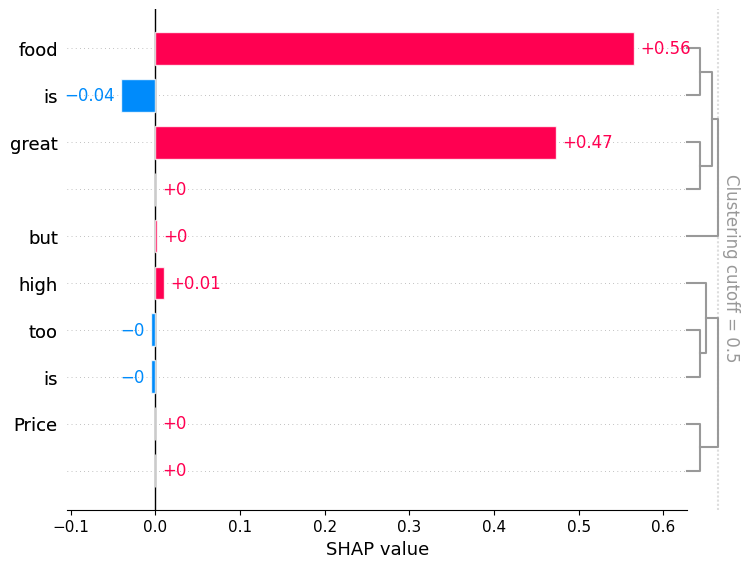

In [ ]:
item=shap_values[:, :, "food-positive"]
print(item)
print(item.clustering)
# print(shap_values.shape)
# print(type(shap_values))
# print(shap_values.clustering)
shap.plots.bar(item[0], clustering=None, clustering_cutoff=0.5)

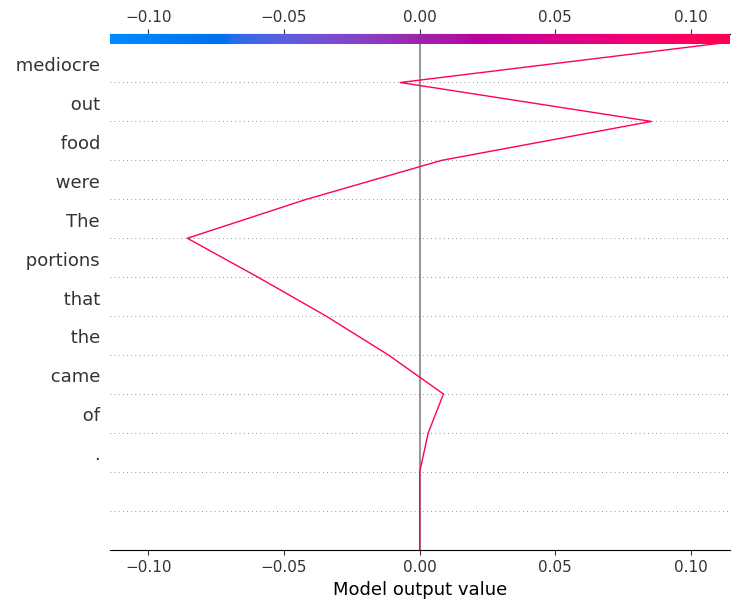

In [ ]:
item=shap_values[:, :, "food-neutral"]
shap.decision_plot(item.base_values, item.values[0], item.data[0])

In [ ]:
!pip install datasets transformers shap

# compute model's performance for ACD and ACP
import math
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

model_checkpoint="UchihaMadara/Thesis-SentimentAnalysis-2"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
model=AutoModelForSequenceClassification.from_pretrained(model_checkpoint)
model.to("cuda")

# define predefined set of aspect categories and polarities
aspectCategories=["food", "service", "price", "ambience", "anecdotes/miscellaneous"]
polarities=["positive", "neutral","negative", "conflict", "none"]

test_dataset=load_dataset("json", data_files="converted2.json")
print(test_dataset)

def compute_aspect_category_polarity(new_sentence):
  # return list of probabilities for each polarity
  # sentence must be reformatted to new format before send to this function
  inputs=tokenizer(new_sentence, return_tensors="pt")
  inputs.to("cuda") # if model haven't be .to("cuda") yet, comment this line
  outputs=model(**inputs)
  logits=outputs.logits # logits shape: n sentence = 1, n polarity=len(polarities)
  return compute_probabilities(logits[0])

def compute_polarity(sentence):
  # return list<list<float>> a
  # a[i][j] = probability that the polarity of aspect category i is j
  new_format="{aspect}... {sentence}"
  a=[]
  for aspect in aspectCategories:
    new_sentence=new_format.format(aspect=aspect, sentence=sentence)
    a.append(compute_aspect_category_polarity(new_sentence))
  return a

def compute_probabilities(logits):
  # normalize logits to probabilities
  list_probabilities=[]
  sum_item=0
  for logit in logits:
    list_item=math.pow(math.e, logit.item())
    list_probabilities.append(list_item)
    sum_item+=list_item
  for i in range(len(list_probabilities)):
    list_probabilities[i]=list_probabilities[i]/sum_item
  return list_probabilities

def evaluate_model():
  # evaluate model for 2 subtask 3 and 4
  total_3=0
  predict_3=0
  predict_correct_3=0
  total_4=0
  correct_4=0
  for record in test_dataset["train"]:
    list_probabilities=compute_polarity(record["text"])
    # compute subtask 3
    subtask3_predict_set=set()
    for i, aspect_probabilities in enumerate(list_probabilities):
      max_polarity=0
      for j, prob in enumerate(aspect_probabilities):
        if prob > aspect_probabilities[max_polarity]:
          max_polarity=j
      if max_polarity != 4:
        # polarity of this aspect is not none
        subtask3_predict_set.add(i)
    subtask3_total_set=set()
    for i, s in enumerate(record["sentiments"]):
      if s!=4:
        subtask3_total_set.add(i)
    subtask3_correct_set=subtask3_predict_set.intersection(subtask3_total_set)
    total_3+=len(subtask3_total_set)
    predict_3+=len(subtask3_predict_set)
    predict_correct_3+=len(subtask3_correct_set)
    # compute subtask 4
    cur_aspect=-1
    for aspect_label, aspect_probability in zip(record["sentiments"], list_probabilities):
      cur_aspect+=1
      if aspect_label==4:
        # aspect_label is none
        continue
      total_4+=1
      max_polarity=0
      for i in range(len(aspect_probability)-1):
        if aspect_probability[i] > aspect_probability[max_polarity]:
          max_polarity=i
      if aspect_label==max_polarity:
        correct_4+=1
      else:
        print("text=",record["text"], "aspect=", aspectCategories[cur_aspect], "true_sentiment=", polarities[aspect_label], "predict_sentiment=", polarities[max_polarity])
  precision_3=predict_correct_3/predict_3
  recall_3=predict_correct_3/total_3
  f1_3=2*(precision_3 * recall_3)/(precision_3+recall_3)
  acc_4=correct_4/total_4
  return {
      "f1_3": f1_3,
      "acc_4": acc_4,
      "precision_3": precision_3,
      "recall_3": recall_3,
      "total_3": total_3,
      "predict_3": predict_3,
      "correct_3": predict_correct_3,
      "total_4": total_4,
      "correct_4": correct_4
  }

evaluate_model()


DatasetDict({
    train: Dataset({
        features: ['sentiments', 'text'],
        num_rows: 800
    })
})
text= menu - uneventful, small. aspect= food true_sentiment= negative predict_sentiment= neutral
text= The portions of the food that came out were mediocre. aspect= food true_sentiment= neutral predict_sentiment= negative
text= How pretentious and inappropriate for MJ Grill to claim that it provides power lunch and dinners! aspect= food true_sentiment= negative predict_sentiment= positive
text= Entrees include classics like lasagna, fettuccine Alfredo and chicken parmigiana. aspect= food true_sentiment= neutral predict_sentiment= positive
text= I wasn't impressed and it wasn't SPICEY???? aspect= food true_sentiment= negative predict_sentiment= positive
text= A nice space, as long as it doesn't get too crowded and a singleminded devotion to its chosen cuisine make Mare a great choice for seafood lovers. aspect= ambience true_sentiment= conflict predict_sentiment= positive
text= T

{'f1_3': 0.9311023622047243,
 'acc_4': 0.8975609756097561,
 'precision_3': 0.9394240317775571,
 'recall_3': 0.9229268292682927,
 'total_3': 1025,
 'predict_3': 1007,
 'correct_3': 946,
 'total_4': 1025,
 'correct_4': 920}